In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [7]:
df = pd.read_csv('lichess_team_games.csv')

In [10]:
# Reorganize data for PCA
df = df[df['event'] != 'Unknown']
df.replace(['Unknown', '?'], np.nan, inplace=True)
df.dropna(subset=['white_elo', 'black_elo', 'result'], inplace=True)
df['result_encoded'] = df['result'].apply(lambda x: 1 if x == '1-0' else (-1 if x == '0-1' else 0))
data = df[['white_elo', 'black_elo', 'result_encoded']].astype(float)

In [11]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)
print("Explained variance by components:", pca.explained_variance_ratio_)

Explained variance by components: [0.90251507 0.09748198]


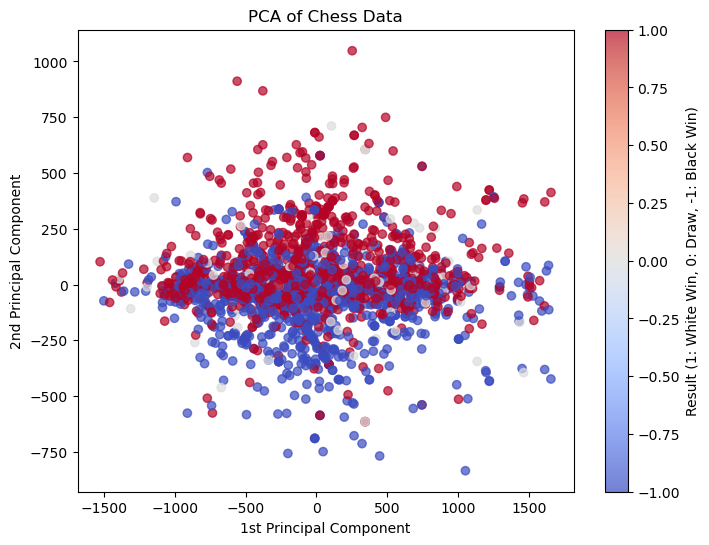

In [12]:
# Plotting
plt.figure(figsize=(8,6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=df['result_encoded'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Result (1: White Win, 0: Draw, -1: Black Win)')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('PCA of Chess Data')
plt.show()

In [23]:
# Find the topmost and lowermost points
# Find indices of the largest and smallest values in the 2nd PC
max_2nd_pc_index = pca_data[:, 1].argmax()
min_2nd_pc_index = pca_data[:, 1].argmin()

# Get their elo ratings
max_2nd_pc_elos = df.iloc[max_2nd_pc_index][['white_elo', 'black_elo']]
min_2nd_pc_elos = df.iloc[min_2nd_pc_index][['white_elo', 'black_elo']]

print("Elo for data point with largest 2nd principal component:")
print(max_2nd_pc_elos)

print("\nElo for data point with smallest 2nd principal component:")
print(min_2nd_pc_elos)


Elo for data point with largest 2nd principal component:
white_elo    2610
black_elo    1122
Name: 3298, dtype: object

Elo for data point with smallest 2nd principal component:
white_elo    1846
black_elo    3019
Name: 1862, dtype: object


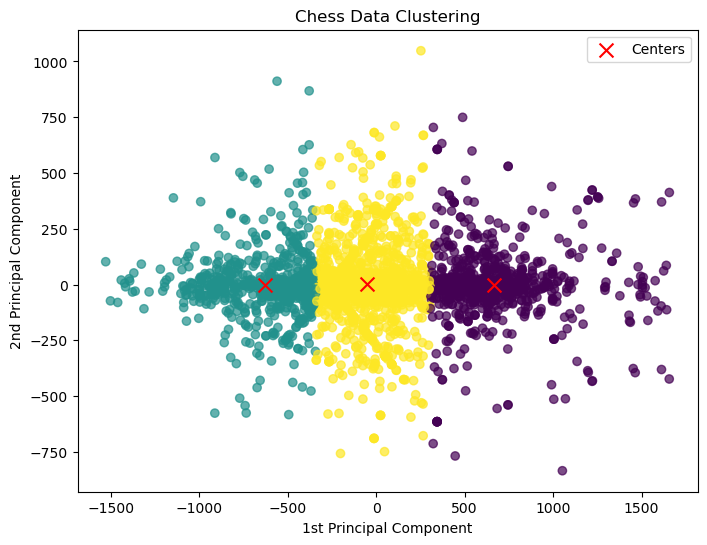

In [17]:
# KMeans Clustering
k = 3  
kmeans = KMeans(n_clusters=k)
kmeans.fit(pca_data)

# Getting centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Plotting
plt.figure(figsize=(8,6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label='Centers')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('Chess Data Clustering')
plt.legend()
plt.show()


In [20]:
# Looking at average values within each cluster

# Conv elos to numeric and get rid of NaNs
df['white_elo'] = pd.to_numeric(df['white_elo'], errors='coerce')
df['black_elo'] = pd.to_numeric(df['black_elo'], errors='coerce')
df = df.dropna(subset=['white_elo', 'black_elo'])

elo_averages = df.groupby('cluster')[['white_elo', 'black_elo']].mean()
print("Average Elo Ratings by Cluster:")
print(elo_averages)

result_counts = df.groupby('cluster')['result_encoded'].value_counts().unstack(fill_value=0)
print("\nGame Outcome Counts by Cluster:")
print(result_counts)


Average Elo Ratings by Cluster:
           white_elo    black_elo
cluster                          
0        2161.170543  2155.288114
1        1245.990014  1242.156919
2        1653.794926  1646.970402

Game Outcome Counts by Cluster:
result_encoded   -1   0    1
cluster                     
0               356  51  367
1               315  30  356
2               657  53  709


# MULTIDIMENSION
### This is overall a failure (perhaps to be revisited)
##### I attempt to create more numeric variables from the other variables provided in the data

In [128]:
df = pd.read_csv('lichess_team_games.csv')
df.replace('Unknown', np.nan, inplace=True)
df.replace('?', 0, inplace=True)
import re

def extract_first_move(moves):
    match = re.search(r'\d+\.\s*([a-hRNBQK][a-h1-8]+)', moves)
    return match.group(1) if match else None

def extract_second_move(moves):
    move_parts = re.split(r'\s+', moves)
    try:
        return move_parts[2] if len(move_parts) > 3 else None
    except IndexError:
        return None

df['moves_next_row'] = df['moves'].shift(-1)
df['first_move_id'] = df['moves_next_row'].apply(lambda x: extract_first_move(str(x)))
df['second_move'] = df['moves_next_row'].apply(lambda x: extract_second_move(str(x)))

df = df[df['event'] != 'Unknown']
df.dropna(subset=['white_elo', 'black_elo', 'result'], inplace=True)
df['result_encoded'] = df['result'].apply(lambda x: 1 if x == '1-0' else (-1 if x == '0-1' else 0))
data = df[['white_elo', 'black_elo', 'result_encoded']].astype(float)
df['eco'] = df['eco'].apply(lambda x: 1 if x != 0 else 0)

df.drop(columns=['moves_next_row'], inplace=True)

In [129]:
# Manually mapping all first moves
first_move_map = {
    'e4': 1, 'e3': 2, 'd4': 3, 'd3': 4,
    'c4': 5, 'c3': 6, 'f4': 7, 'f3': 8,
    'g4': 9, 'g3': 10, 'b4': 11, 'b3': 12,
    'a4': 13, 'a3': 14, 'h4': 15, 'h3': 16,
    'Nf3': 17, 'Nc3': 18, 'Na3': 19, 'Nh3': 20
}
second_move_map = {
    'e5': 1, 'e6': 2, 'd5': 3, 'd6': 4,
    'c5': 5, 'c6': 6, 'f5': 7, 'f6': 8,
    'g5': 9, 'g6': 10, 'b5': 11, 'b6': 12,
    'a5': 13, 'a6': 14, 'h5': 15, 'h6': 16,
    'Nf6': 17, 'Nc6': 18, 'Na6': 19, 'Nh6': 20
}

df['first_move_id'] = df['first_move_id'].map(first_move_map)
df['second_move_id'] = df['second_move'].map(second_move_map)

print(df[['first_move_id', 'second_move_id']].head())

   first_move_id  second_move_id
0           17.0             8.0
2           17.0             8.0
4           17.0             8.0
6           10.0            10.0
8           12.0            10.0


   black_elo  white_elo  result_encoded  eco  first_move_id  second_move_id
0     1582.0     1477.0            -1.0  0.0           17.0             8.0
2     1594.0     1577.0             1.0  0.0           17.0             8.0
4     1794.0     1708.0             1.0  0.0           17.0             8.0
6     1609.0     1457.0            -1.0  0.0           10.0            10.0
8     1470.0     1564.0             1.0  0.0           12.0            10.0
NaN values in each column before PCA:
 black_elo           0
white_elo           0
result_encoded      0
eco                 0
first_move_id      92
second_move_id    113
dtype: int64
Infinite values in each column before PCA:
 black_elo         0
white_elo         0
result_encoded    0
eco               0
first_move_id     0
second_move_id    0
dtype: int64
Explained variance by components: [0.74376143 0.25615093]


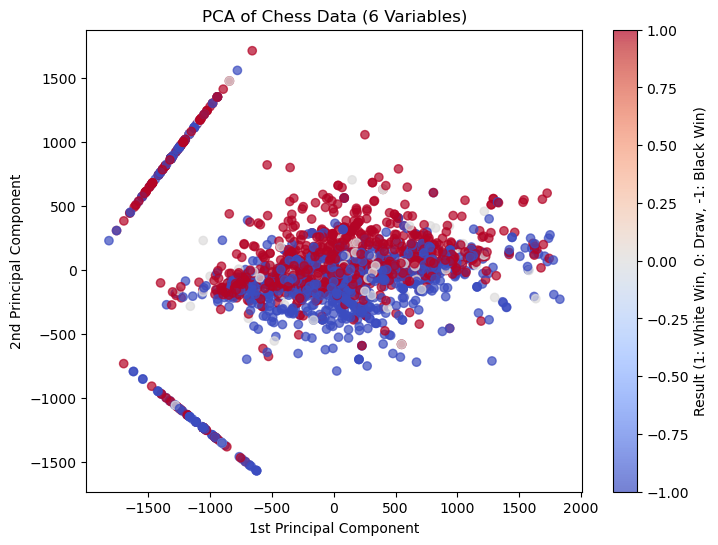

In [130]:
data = df[['black_elo', 'white_elo', 'result_encoded', 'eco', 'first_move_id', 'second_move_id']].astype(float)
print(data.head(5))
print("NaN values in each column before PCA:\n", data.isna().sum())
print("Infinite values in each column before PCA:\n", np.isinf(data).sum())

data.fillna(data.mean(), inplace=True)
data.replace([np.inf, -np.inf], 0, inplace=True)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

print("Explained variance by components:", pca.explained_variance_ratio_)

plt.figure(figsize=(8,6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=df['result_encoded'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Result (1: White Win, 0: Draw, -1: Black Win)')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('PCA of Chess Data (6 Variables)')
plt.show()

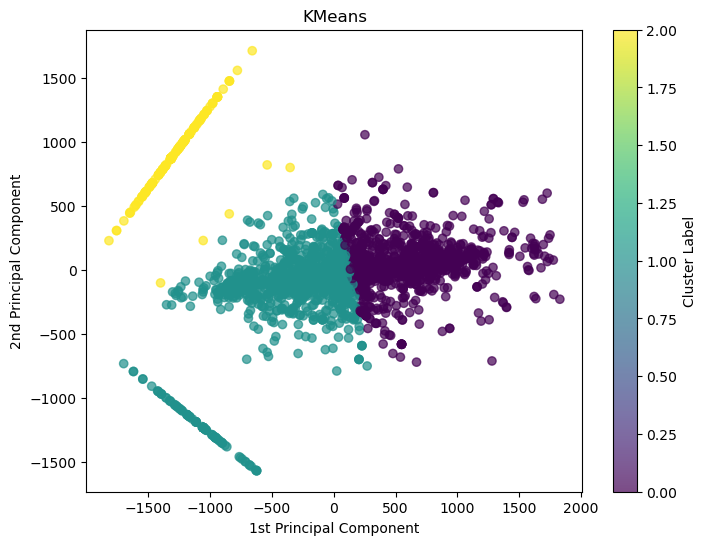

In [127]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_data)

plt.figure(figsize=(8,6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster Label')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('KMeans')
plt.show()